In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [3]:
!pip install -q torch torchvision transformers timm sentencepiece


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import pandas as pd
import os


In [5]:
print(torch.cuda.is_available())


True


In [9]:
import pandas as pd

caption_file = "/kaggle/input/flickr8k/captions.txt"

df = pd.read_csv(caption_file)
df.columns = ["image", "caption"]

df.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [10]:
print("Images:", df["image"].nunique())
print("Captions:", len(df))


Images: 8091
Captions: 40455


In [12]:
from transformers import ViTModel, ViTImageProcessor

vision_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

vision_model = vision_model.cuda().eval()


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
img_path = "/kaggle/input/flickr8k/Images/" + df.iloc[0]["image"]
image = Image.open(img_path).convert("RGB")

inputs = image_processor(images=image, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = vision_model(**inputs)
    img_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token

print(img_embedding.shape)


torch.Size([1, 768])


In [14]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_model = AutoModel.from_pretrained("distilbert-base-uncased")

text_model = text_model.cuda().eval()
text = df.iloc[0]["caption"]

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to("cuda")

with torch.no_grad():
    outputs = text_model(**inputs)
    text_embedding = outputs.last_hidden_state[:, 0, :]

print(text_embedding.shape)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

torch.Size([1, 768])


In [15]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=768, output_dim=512):
        super().__init__()
        self.proj = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.proj(x)
        x = F.normalize(x, dim=-1)  # VERY IMPORTANT
        return x


In [16]:
image_proj = ProjectionHead().cuda()
text_proj = ProjectionHead().cuda()


In [17]:
for param in vision_model.parameters():
    param.requires_grad = False

for param in text_model.parameters():
    param.requires_grad = False


In [18]:
def contrastive_loss(image_embeds, text_embeds, temperature=0.07):
    logits = image_embeds @ text_embeds.T / temperature
    labels = torch.arange(len(logits)).to(logits.device)

    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.T, labels)

    return (loss_i + loss_t) / 2


In [19]:
optimizer = torch.optim.AdamW(
    list(image_proj.parameters()) + list(text_proj.parameters()),
    lr=1e-4
)


In [20]:
from torch.utils.data import DataLoader
from tqdm import tqdm


In [21]:
class FlickrDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_root):
        self.df = df
        self.image_root = image_root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(
            os.path.join(self.image_root, row["image"])
        ).convert("RGB")

        return image, row["caption"]


In [22]:
dataset = FlickrDataset(df, "/kaggle/input/flickr8k/Images")
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [24]:
def collate_fn(batch):
    images, captions = zip(*batch)
    return list(images), list(captions)


In [25]:
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)


In [26]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=768, output_dim=512):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return F.normalize(x, dim=-1)


In [27]:
image_proj = ProjectionHead().cuda()
text_proj = ProjectionHead().cuda()


In [28]:
optimizer = torch.optim.AdamW(
    list(image_proj.parameters()) + list(text_proj.parameters()),
    lr=1e-4
)


In [29]:
vision_model.eval()
text_model.eval()

for epoch in range(5):
    total_loss = 0

    for images, captions in tqdm(loader, desc=f"Epoch {epoch+1}"):

        image_inputs = image_processor(
            images=images,
            return_tensors="pt"
        ).to("cuda")

        text_inputs = tokenizer(
            captions,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to("cuda")

        with torch.no_grad():
            img_feats = vision_model(**image_inputs).last_hidden_state[:, 0, :]
            txt_feats = text_model(**text_inputs).last_hidden_state[:, 0, :]

        img_embeds = image_proj(img_feats)
        txt_embeds = text_proj(txt_feats)

        loss = contrastive_loss(img_embeds, txt_embeds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader):.4f}")


Epoch 1: 100%|██████████| 1265/1265 [09:46<00:00,  2.16it/s]


Epoch 1 Avg Loss: 1.3179


Epoch 2: 100%|██████████| 1265/1265 [08:36<00:00,  2.45it/s]


Epoch 2 Avg Loss: 0.7591


Epoch 3: 100%|██████████| 1265/1265 [08:38<00:00,  2.44it/s]


Epoch 3 Avg Loss: 0.6183


Epoch 4: 100%|██████████| 1265/1265 [08:34<00:00,  2.46it/s]


Epoch 4 Avg Loss: 0.5414


Epoch 5: 100%|██████████| 1265/1265 [08:34<00:00,  2.46it/s]

Epoch 5 Avg Loss: 0.4876


In [30]:
vision_model.eval()
text_model.eval()
image_proj.eval()
text_proj.eval()


ProjectionHead(
  (fc): Linear(in_features=768, out_features=512, bias=True)
)

In [32]:
image_embeddings = []
image_paths = []

with torch.no_grad():
    for idx in tqdm(range(len(dataset)), desc="Encoding images"):
        image, caption = dataset[idx]

        image_inputs = image_processor(
            images=image,
            return_tensors="pt"
        ).to("cuda")

        img_feat = vision_model(**image_inputs).last_hidden_state[:, 0, :]
        img_embed = image_proj(img_feat)

        image_embeddings.append(img_embed.cpu())
        image_paths.append(df.iloc[idx]["image"])

image_embeddings = torch.cat(image_embeddings)


Encoding images: 100%|██████████| 40455/40455 [11:56<00:00, 56.45it/s]


In [33]:
def semantic_image_search(query, top_k=5):
    with torch.no_grad():
        text_inputs = tokenizer(
            query,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to("cuda")

        text_feat = text_model(**text_inputs).last_hidden_state[:, 0, :]
        text_embed = text_proj(text_feat)

        similarities = (text_embed.cpu() @ image_embeddings.T).squeeze(0)
        top_indices = similarities.topk(top_k).indices

    return [(image_paths[i], similarities[i].item()) for i in top_indices]


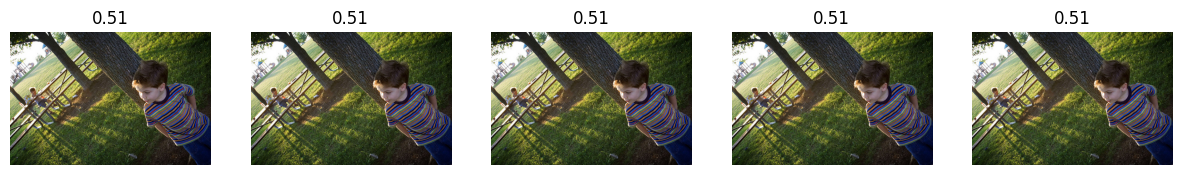

In [55]:
results = semantic_image_search(
    "a child playing with a dog on grass",
    top_k=5
)

import matplotlib.pyplot as plt

def show_results(results):
    plt.figure(figsize=(15,5))
    for i, (img_name, score) in enumerate(results):
        img = Image.open(
            os.path.join("/kaggle/input/flickr8k/Images", img_name)
        )
        plt.subplot(1, len(results), i+1)
        plt.imshow(img)
        plt.title(f"{score:.2f}")
        plt.axis("off")
    plt.show()

show_results(results)

In [54]:
torch.save(image_proj.state_dict(), "image_projection.pt")
torch.save(text_proj.state_dict(), "text_projection.pt")
torch.save(image_embeddings, "image_embeddings.pt")

